In [34]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display


# Gravity gradient torque from Neptune
mu = 6.836529e15
R = 27e6
boom_mass = 6
boom_length = 32.5
additional_boom_end_mass = 0.234 * 2

Iz = (4 * ((boom_mass * (boom_length ** 2)) / 3) + (additional_boom_end_mass * (boom_length ** 2)))
Ix = Iz / 2
Iy = Iz / 2
theta_x = np.pi/2
theta_y = np.pi/2

Tgx = 3 * (mu / (2 * R ** 3)) * np.abs(Iz - Iy)
Tgy = 3 * (mu / (2 * R ** 3)) * np.abs(Iz - Ix)
print(f"Tgy: {Tgy}, Tgx: {Tgx}")

total_momentum_storage = (Tgy + Tgx) * 2.5 * 60 * 60 * 24
print("Total momentum storage over the course of the mission:", total_momentum_storage)


Tgy: 0.0023299854156350022, Tgx: 0.0023299854156350022
Total momentum storage over the course of the mission: 1006.553699554321


In [35]:

# Gravity gradient torque from Triton
mu = 2.139e22 * 6.67430e-11
R = (3e3 + 1353.39393) * 1000
boom_mass = 6
boom_length = 32.5
additional_boom_end_mass = 0.234 * 2

Iz = (4 * ((boom_mass * boom_length ** 2) / 3) + (additional_boom_end_mass * boom_length ** 2))
Ix = Iz / 2
Iy = Iz / 2
theta_x = np.pi/2
theta_y = np.pi/2

Tgx = 3 * (mu / (2 * R ** 3)) * np.abs(Iz - Iy)
Tgy = 3 * (mu / (2 * R ** 3)) * np.abs(Iz - Ix)
print(f"Tgy: {Tgy}, Tgx: {Tgx}")

total_momentum_storage = (Tgy + Tgx) * 2.5 * 60 * 60 * 24
print("Total momentum storage over the course of the mission:", total_momentum_storage)

Tgy: 0.00011607573458416634, Tgx: 0.00011607573458416634
Total momentum storage over the course of the mission: 50.14471734035986


In [36]:
# Calculation for torque producted from electrospray thrusters on one axis

force_per_thruster_unit = 5e-6
single_unit_mass = 1.8e-2
power_consumption_per_unit = 1e-2
desired_torque_output = 0.00028 
number_of_units_per_array = math.ceil(desired_torque_output / (force_per_thruster_unit * boom_length * 4))
print(number_of_units_per_array) # ~ 1 (2x the value given)
# ethruster_array_mass = 
# ethruster_array_power_usage = 130e-3

thruster_arrays = 8

print("Total mass of all e-thrusters: ", single_unit_mass * number_of_units_per_array * thruster_arrays) # total ethrusters system mass
print("Total power consumption for all e-thrusters: ", power_consumption_per_unit * number_of_units_per_array * thruster_arrays) # total power consumption for ethrusters


1
Total mass of all e-thrusters:  0.144
Total power consumption for all e-thrusters:  0.08


In [37]:
def allocation(a, I, esp_thrust_max, cmg_tau_max, cmg_l_max, boom_length, tolerance, e_arcmin, cmg_unload_rate, timestep, cmg_l, cmg_utilization_coefficient):
    # a input in rad/s^2
    # cmg_unload_rate defines the percent of fastest momentum dump rate that will be tolerated as a percentage of max unload rate
    # set percent CMG and ESP utilization to 0
    empty_dict = dict()
    usage = dict()
    usage['esp'] = 0.0
    usage['cmg'] = 0.0
    usage['l'] = 0.0

    # calculate required tau, and max ESP tau
    tau = np.abs(I * a)
    esp_tau_max = esp_thrust_max * boom_length
    
    # calculate CMG momentum tolerance
    cmg_l_tol = cmg_l_max * float(tolerance)

   # sign of angular acceleration
    if a == 0:
        sign = 0
    else:
        sign = a/np.abs(a) 


    # if desired torque is beyond system capability
    if tau > (esp_tau_max + cmg_tau_max):
        usage['esp'] = 1.0
        if cmg_l < cmg_l_tol:
            usage['cmg'] = 1.0
            cmg_l = (sign) * usage['cmg'] * cmg_tau_max * timestep + cmg_l # update saturation of CMG
    
    # if error is less than 0.1 arcmin (25% of budget), begin unloading momentum by counter-torquing ESPs and CMGs
    elif (e_arcmin >= 0.1 and e_arcmin <= 0.1) and tau <= esp_tau_max:
        usage['esp'] = tau / esp_tau_max
        if cmg_l > 0: # might want to fix to ensure that momentum storage does not become negative
            unload_tau = (esp_tau_max - usage['esp'] * esp_tau_max) * cmg_unload_rate
            usage['esp'] = (tau + unload_tau) / esp_tau_max
            usage['cmg'] = unload_tau / cmg_tau_max
            cmg_l = cmg_l - unload_tau * usage['cmg']

    # if CMGs are fully saturated and system is not near desired position:
    elif cmg_l >= cmg_l_tol:
        usage['esp'] = tau / esp_tau_max
        usage['cmg'] = 0.0

    # if CMGs are not fully saturated and system is not near desired position:
    elif cmg_l < cmg_l_tol:
        # if desired torque is less than maximum capacity of CMGs:
        if tau <= cmg_tau_max:
            usage['cmg'] = cmg_utilization_coefficient * tau / cmg_tau_max
            cmg_l = (usage['cmg'] * cmg_tau_max) * timestep * sign + cmg_l # update saturation of CMG
            usage['esp'] = (1 - cmg_utilization_coefficient) * tau / esp_tau_max
        # if desired torque is greater than capacity of CMGs:
        elif np.abs(tau) >= cmg_tau_max:
            usage['cmg'] = 1.0 * cmg_utilization_coefficient
            usage['esp'] = (tau - (cmg_tau_max * cmg_utilization_coefficient)) / esp_tau_max
            cmg_l = (usage['cmg'] * cmg_tau_max) * timestep * sign + cmg_l # update saturation of CMG
    
    usage['l'] = cmg_l # update momentum storage

    if usage['esp'] > 1 or usage['cmg'] > 1:
        print("Oversaturated.")

    return usage

In [38]:
saturation = np.empty([1,1], dtype=float)
cmg_tau_max = 0.002
cmg_l_max = 0.02
rad_conversion = 60 * 180 / np.pi # radian-to-arcminute conversion

array_size = 5

n = 300 # time points to plot
error = np.zeros(n) # array to store error
alpha = np.zeros(n) # array to store angular acceleration
tf = 300.0 # final time
SP_start = 2.0 # time of set point change
ci = 50

esp_tau_max = (force_per_thruster_unit * boom_length * array_size)

t = np.linspace(0,tf,n) # create time vector

tstep = tf / n

SPs = np.random.randint(0, 2, ci)
final_e = np.ones(n // ci)

def process(y,t,u):
	Kp = 4.0
	taup = 3.0
	thetap = 1.0
	if t<(thetap+SP_start):
		dydt = 0.0  # time delay
	else:
		dydt = (1.0/taup) * (-y + Kp * u)
	return dydt

def pidPlot(Kc,tauI,tauD):
	t = np.linspace(0,tf,n) # create time vector
	P= np.zeros(n)          # initialize proportional term
	I = np.zeros(n)         # initialize integral term
	D = np.zeros(n)         # initialize derivative term
	e = np.zeros(n)         # initialize error
	OP = np.zeros(n)        # initialize controller output
	PV = np.zeros(n)        # initialize process variable
	SP = np.zeros(n)        # initialize setpoint

	# alpha_x = Tgx / Ix
	# delta_theta = 0.5 * alpha_x * ((tf / n) ** 2)
	# delta_theta_arcmin = delta_theta * 216e2 / (2 * np.pi) 
	SP_step = int(SP_start/(tf/(n-1))+1) # setpoint start
	SP[0:SP_step] = 0.0     # define setpoint
	SP[SP_step:n] = 4.0     # step up
	y0 = 0.0                # initial condition

	max_possible_tau = force_per_thruster_unit * boom_length # calculate max possible torque from ACS
	j = 0 # saturation counter

	for i in range(n):	
		SP[i] = SPs[i // ci]
	# loop through all time steps
	for i in range(1,n):
		# simulate process for one time step
		ts = [t[i-1],t[i]]         # time interval -- should this be calculated every time?
		y = odeint(process,y0,ts,args=(OP[i-1],))  # compute next step
		temp = y0
		y0 = y[1]                  # record new initial condition
	
		# arcmin -> rad: * np.pi / (60 * 180)
		# calculate new OP with PID
		PV[i] = y[1]               # record PV
		a = (((y0 - temp) / tstep) - ((temp - PV[i-1]) / tstep)) / tstep # comparing slope of current timestep and previous timestep to find angular acceleration
		alpha[i] = a
		# tau = Iz * (a * np.pi / (60 * 180)) # convert alpha from arcmin/s^2 to rad/s^2
		tau = Iz * a
		
		if tau > max_possible_tau:
			PV[i] = temp + 0.5 * (max_possible_tau / Iz) * (tstep ** 2)	# record PV: use kinematic formulas to calculate angular displacement if desired tau is beyond system capacity-- should this be calculated every time?
			j += 1
			# add saturation time to array
			saturation.resize((1,j), refcheck=False)
			saturation[0, j-1] = t[i]
		elif tau < -max_possible_tau:
			PV[i] = temp - 0.5 * (max_possible_tau / Iz) * (tstep ** 2)	# record PV: use kinematic formulas to calculate angular displacement if desired tau is beyond system capacity-- should this be calculated every time?	
			j += 1
			# add saturation time to array
			saturation.resize((1,j), refcheck=False)
			saturation[0, j-1] = t[i]
		e[i] = SP[i] - PV[i]       # calculate error = SP - PV
		error[i] = e[i] * rad_conversion # store error in arcmin
		dt = t[i] - t[i-1]         # calculate time step
		P[i] = Kc * e[i]           # calculate proportional term
		I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
		D[i] = -Kc * tauD * (PV[i]-PV[i-1])/dt # calculate derivative term
		OP[i] = P[i] + I[i] + D[i] # calculate new controller output

	print(f"ACS saturated a total of {j} times during operation. Saturation at:")
	if j > 0:
		print(saturation)
	for i in range(n):
		final_e[i//ci] = e[i]

	# plot PID response
	plt.figure(1,figsize=(15,7))
	plt.subplot(2,2,1)
	plt.plot(t,SP,'k-',linewidth=2,label='Setpoint (SP)')
	plt.plot(t,PV,'r-',linewidth=2,label='Process Variable (PV)')
	plt.legend(loc='best')
	plt.subplot(2,2,2)
	plt.plot(t,P,'g.-',linewidth=2,label=r'Proportional = $K_c \; e(t)$')
	plt.plot(t,I,'b-',linewidth=2,label=r'Integral = $\frac{K_c}{\tau_I} \int_{i=0}^{n_t} e(t) \; dt $')
	plt.plot(t,D,'r--',linewidth=2,label=r'Derivative = $-K_c \tau_D \frac{d(PV)}{dt}$')    
	plt.legend(loc='best')
	plt.subplot(2,2,3)
	plt.plot(t,e,'m--',linewidth=2,label='Error (e=SP-PV)')
	plt.legend(loc='best')
	plt.subplot(2,2,4)
	plt.plot(t,OP,'b--',linewidth=2,label='Controller Output (OP)')
	plt.legend(loc='best')
	plt.xlabel('time')

Kc_slide = wg.FloatSlider(value=0.24,min=-0.2,max=1.0,step=0.0001) # 0.25
tauI_slide = wg.FloatSlider(value=2.46,min=0.01,max=5.0,step=0.0001) # 4.00
tauD_slide = wg.FloatSlider(value=0.0,min=0.0,max=1.0,step=0.0001) # 0.00
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide)
print(np.max(final_e))

interactive(children=(FloatSlider(value=0.24, description='Kc', max=1.0, min=-0.2, step=0.0001), FloatSlider(v…

1.6767143229401427e-11


Observation window throughout 97.33333333333334% of mission.


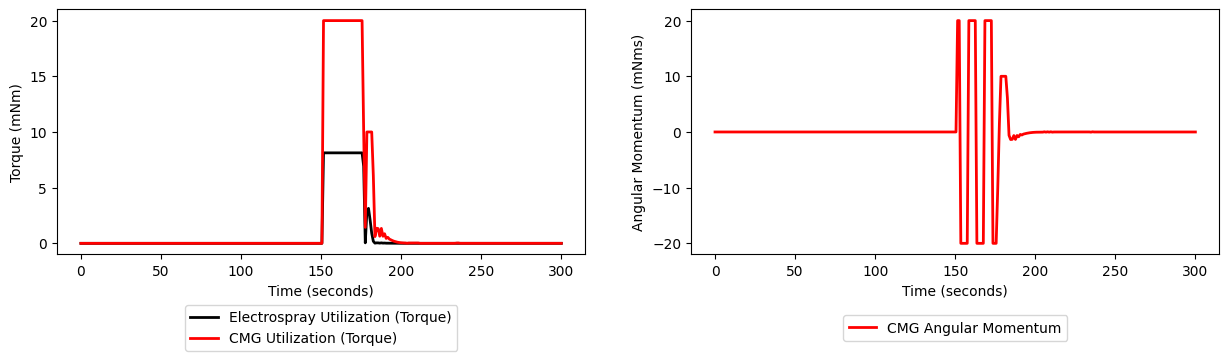

In [39]:
esp_tau = np.zeros(n)
cmg_tau = np.zeros(n)
cmg_l = np.zeros(n)
tolerance = 1
cmg_unload_rate = 0.5
cmg_utilization_coefficient = 0.5

for i in range(1,n):
    esp_tau[i] = esp_tau_max * allocation(alpha[i], Iz, esp_tau_max, cmg_tau_max, cmg_l_max, boom_length, tolerance, error[i], cmg_unload_rate, tstep, cmg_l[i], cmg_utilization_coefficient)['esp'] * (10e3)
    cmg_tau[i] = cmg_tau_max * allocation(alpha[i], Iz, esp_tau_max, cmg_tau_max, cmg_l_max, boom_length, tolerance, error[i], cmg_unload_rate, tstep, cmg_l[i], cmg_utilization_coefficient)['cmg'] * (10e3)
    cmg_l[i] = allocation(alpha[i], Iz, esp_tau_max, cmg_tau_max, cmg_l_max, boom_length, tolerance, error[i], cmg_unload_rate, tstep, cmg_l[i], cmg_utilization_coefficient)['l'] * (10e3)

acceptable_error_count = 0

for i in range(0,n):
    if error[i] < 0.4:
        acceptable_error_count += 1

error_percentage = (acceptable_error_count / n) * 100

print(f"Observation window throughout {error_percentage}% of mission.")

        

plt.figure(1,figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(t,esp_tau,'k-',linewidth=2,label='Electrospray Utilization (Torque)')
plt.plot(t,cmg_tau,'r-',linewidth=2,label='CMG Utilization (Torque)')
plt.xlabel("Time (seconds)")
plt.ylabel("Torque (mNm)")
plt.legend(bbox_to_anchor=(0.5, -0.3), loc='center', borderaxespad=0)
plt.subplot(2,2,2)
plt.plot(t,cmg_l,'r-',linewidth=2,label='CMG Angular Momentum')
plt.ylabel("Angular Momentum (mNms)")
plt.xlabel("Time (seconds)")
plt.legend(bbox_to_anchor=(0.5, -0.3), loc='center', borderaxespad=0)
plt.show()
